# [IAPR][iapr]: Project


**Group ID:** 32

**Author 1 (sciper):** Ghali CHRAIBI (262251)  
**Author 2 (sciper):** Yann Yasser HADDAD (272292)   
**Author 3 (sciper):** Julien BERGER (xxxxx)   

**Release date:** 07.05.2021  
**Due date:** 03.06.2021 (23h59)


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class as well as preparation for the final project, which is a practical project which ties together the topics of the course. 

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook !** rerun the notebook from scratch `Kernel` > `Restart & Run All`


[iapr]: https://github.com/LTS5/iapr

## Imports 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2
import skimage.io
from skimage import img_as_ubyte

from utils import rgb_to_hsv, split_img, plot_histogram, print_results, evaluate_game

---
## 0. Introduction

An anonymous researcher that we will name Lann Yecun is convinced that the MNIST dataset still has great potential. He decides to create a playing card game based on MNIST digits and different figures. The game uses a standard 52 card deck which is composed of four French suits/colours: clubs (&#9827;), diamonds (&#9830;), hearts (&#9829;) and spades (&#9824;). Each suit includes 10 digit cards (from 0 to 9) and 3 figures (Jack-J, Queen-Q, and King-K). Here is an example of the 13 spade cards with their name.


<img src="data/media/example_cards.png">


We can find the same arrangement of cards for the clubs, diamonds, and hearts. 


## 1. Rules


### 1.1 Standard

The rules are based on the simple battle card game. The goal of the game is to win as many points as possible. Each turn, the 4 players play a card in front of them. As displayed in the example below. The rules are the following:

- The cards are ranked in the following order : **0 < 1 < 2 < 3 < 4 < 5 < 6 < 7 < 8 < 9 < J < Q < K**.
- The player with the highest-ranked card wins the round and obtains **1 point**. 
- If the highest-ranked card is the same for multiple players we call it a draw and all winners get **1 points**. 
- In this configuration, we **do not** take into account the suits. The game only rely on the card ranks. 
- The game lasts 13 rounds. After the last round, the winner is the player that has the largest number of points. 
- In the example below Player 1 wins the round with his Queen ( 0 < 8 < J < **Q**).

If two or more players have the same number of points they share the victory.

### 1.2 Advanced

The advanced rules take into account the suits. 

- At the beginning of **each round** a random player is designated as the **dealer**. The dealer places a green token with the letter *D* next to him (player 1 in the example below).
- Only the cards that belong to the same suit as the one of the dealer are considered valid. In the example below, only Player 4 is competing with Player 1 as spade was selected by the dealer (e.i., Player 1). Player 2 and 3 are out for this round. Player 1 wins the round and **1 point** with the Queen ( 0&#9824; < **Q&#9824;**).
- There cannot be any draw between the players as they are not any card duplicates.
- We use the same system as the standard method to count the points.


<img src="data/media/example_round.jpg">


### 1.3 Notes

- The orientation of the card is linked to the position of the player around the table. For instance, to read the card of the 3rd player you will have to rotate it by 180°.
- The **digits** always **face** the players around the table. The figures can have random orientations.
- Player 1 **always** seats south of the table. The players are **always** ordered counter-clockwise as in the example. 
- The dealers can change between the rounds and games.
- Some cards **might** apear multiple times per game.
- Pictures are always taken from rougthly the same altitude.
- The digits from the training set **would not** be the same as the one of the testing set.

---
## 2. Data

You will be given the images of 7 games that were played ([download link](https://drive.google.com/drive/folders/1fEy27wnJsUJPRsEEomzoAtP56s-7HFtk?usp=sharing)). The data are composed of:
   - 7 folder named after the games (game1 to game7).
   - Each game includes 13 ordered images (1st to 13th round).
   - Each game includes a csv file with the ground truth of the game. The first row list the players (P1 to P4) as well as the dealer (D). The following rows represent the rounds (1 to 13). We represent the card played with 2 character as $AB$ where $A \in [0-9, J, Q, K]$ is the rank of the card and $B \in [C, D, H, S]$ is the suit. For example, QS means "(Q)ueen of (S)pade" and 0D means "(0) of (D)iamond". The dealer is represented by the ID of the player (e.g. P1 -> 1).
   
You are free to use external datasets such as the original MNIST train set that you used in lab 3.

### Data loading

In [ ]:
train_data = 'data/train_games'
train_game_count = 7
game_round_count = 13

dict_data = {}

for i in range(1, train_game_count+1):
    # For each game, store the path of the csv and the image of each round
    dict_data[f'game{i}'] = {}
    dict_data[f'game{i}']['url'] = train_data + f'/game{i}'
    dict_data[f'game{i}']['csv'] = train_data + f'/game{i}.csv'
    
    for j in range(1, game_round_count+1):
        dict_data[f'game{i}'][f'round{j}'] = skimage.io.imread(train_data + f'/game{i}/{j}.jpg')

### Data visualisation

In [ ]:
def visualise_img(img=None,
                  contours=None, nbr_contours=5,
                  dict_data=dict_data, game=1, round_nb=1):
    
    # If no image was given (None), take an image from dict_data
    if img is None:
        img = dict_data[f'game{game}'][f'round{round_nb}']
    img_to_display = img.copy()
    
    # If there are contours, add them on top of the img
    if contours is not None:
        img_to_display = cv2.drawContours(img_to_display, contours[:nbr_contours], -1, (255,0,0), 10)
    
    # Display image
    fig, ax = plt.subplots(1, 1, figsize=(6, 8))
    ax.imshow(img_to_display, cmap='gray')
    ax.set_title(f'Game {game} - Round {round_nb}')
    ax.axis('off')
    plt.show()

In [ ]:
def visualise_game(withContours=False, debug=False):
    fig, ax = plt.subplots(train_game_count, game_round_count, figsize=(40, 40))
    
    for i in range(1, train_game_count+1):
        for j in range(1, game_round_count+1):
            img = dict_data[f'game{i}'][f'round{j}']  
            img_to_display = img.copy()
            
            # Draw the processed image
            if debug:
                _, _, _, img_processed_chip = detect_dealer_chip(img_to_display)
                contour_cards, img_to_display = detect_cards(img_to_display, img_processed_chip)
            
            # Draw contours if asked
            if withContours:
                contour_chip, centers, radius, img_processed_chip = detect_dealer_chip(img_to_display)
                contour_cards, img_processed_card = detect_cards(img_to_display, img_processed_chip)
                
                # Draw the contour of the cards
                img_to_display = cv2.drawContours(img_to_display, contour_cards, -1, (255,0,0), 10)
                
                # Draw the contour of the chip
                #img_to_display = cv2.drawContours(img_to_display, contour_chip, -1, (255,0,0), 10)
                
                # Draw the enclosing circle of the chip
                img_to_display = cv2.circle(img_to_display, (int(centers[0]), int(centers[1])), 
                                            int(radius), (0,0,255), 10)

            ax[i-1,j-1].imshow(img_to_display, cmap='gray')
            ax[i-1,j-1].set_title(f'Game {i} - Round {j}')
            ax[i-1,j-1].axis('off')
    
    plt.show()

In [ ]:
visualise_img()

In [ ]:
visualise_game(debug=True)

---
## 3. Your Tasks

Your task is to ready yourself for the final evaluation. The day of the exam we will give you a new folder with a new game. ! The digits on the cards **differ** from the one of the traning set. When given a new data folder with 13 images your should be able to:

**Task 0**
   - Plot an overlay for each round image that shows your detections and classification. You can for example plot bounding boxes around the cards/dealer token and add a text overlay with the name of the classes.

**Task 1**
   - (a) Predict the **rank** of the card played by each player at each round (Standard rules).
   - (b) Predict the **number of points** of each player according to **Standard** rules
 
**Task 2**
   - (a) Detect which player is the selected **dealer** for each round.
   - (b) Predict the **rank** and the **suit** of the card played by each player at each round (Advanced rules).
   - (c) Predict the **number of points** of each player according to **Advanced** rules

---

**Before the exam (until 03.06.21 at 23h59)**
   - Create a zipped folder named **group_xx.zip** that you upload on moodle (xx being your group number).
   - Include a **runnable** code (Jupyter Notebook and external files) and your presentation in the zip folder.
   
**The day of the exam (04.06.21)**
   - You will be given a **new folder** with 13 images (rounds) and but **no ground truth** (csv file).
   - We will ask you to run your pipeline in **realtime** and to send us your prediction of task 1 and 2 that you obtain with the function **print_results**. 
   - On our side we will compute the perfomance of your classification algorithm. 
   - To evaluate your method we will use the **evaluate_game** function presented below. To understand how the provided functions work please read the documentation of the functions in **utils.py**.
   - **Please make sure your function returns the proper data format to avoid points penalty the day of the exam**. 

### Task 0

In [ ]:
def split_2d_img(img):
    height, width = img.shape[0], img.shape[1]
    
    # Boarders of the img
    top_lim = int(0.32*height)
    bot_lim = int(0.68*height)
    horizontal_lim = int(width/2)
    
    # Note that height => y and width => x
    translation_to_org = {
        'Player 1': {'x':0, 'y':bot_lim},
        'Player 2': {'x':horizontal_lim, 'y':top_lim}, 
        'Player 3': {'x':0, 'y':0}, 
        'Player 4': {'x':0, 'y':top_lim}
    }
    
    top_img = img[:top_lim, :]
    bot_img = img[bot_lim:, :]
    left_img = img[top_lim:bot_lim, :horizontal_lim]
    right_img = img[top_lim:bot_lim, horizontal_lim:]
    
    imgs = {'Player 1':bot_img, 'Player 2':right_img, 'Player 3':top_img, 'Player 4':left_img}
    
    return imgs, translation_to_org

In [ ]:
def find_sorted_contours(img):
    # Find the contours of our image
    contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Sort the contours by area covered within the contours
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    
    return contours

In [ ]:
def detect_dealer_chip(img):
    # Convert RGB to HSV image
    hsv_img = rgb_to_hsv(img)
    
    # Split the image
    hue_img, sat_img, val_img = split_img(hsv_img)
    
    # Threshold the image and transform it to a binary image
    img_processed = (hue_img > 60) & (hue_img < 120) & (sat_img > 90) & (sat_img < 180)
    
    # Convert the image from binary to [0-255]
    img_processed = img_as_ubyte(img_processed)
    
    # Apply a closing to the image (close the holes in the dealer chip)
    kernel_ell = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(15,15))
    img_processed = cv2.morphologyEx(img_processed, cv2.MORPH_CLOSE, kernel_ell)

    # Apply an opening to the image (remove the cards)
    kernel_rec = cv2.getStructuringElement(cv2.MORPH_RECT,(45,45))
    img_processed = cv2.morphologyEx(img_processed, cv2.MORPH_OPEN, kernel_rec)
    
    # Find the contour & the enclosing circle of the chip
    contour_chip = find_sorted_contours(img_processed)[0]
                
    contour_chip_poly = cv2.approxPolyDP(contour_chip, 3, True)
    centers, radius = cv2.minEnclosingCircle(contour_chip_poly)
    
    return contour_chip, centers, radius, img_processed

In [ ]:
def detect_cards(img, img_processed_chip):
    
    ### Process the image ###
    
    # Convert RGB to HSV image
    hsv_img = rgb_to_hsv(img)
    
    # Split the image
    hue_img, sat_img, val_img = split_img(hsv_img)
    
    # Threshold the image and transform it to a binary image
    img_processed = (hue_img > 60) & (hue_img < 120) & (sat_img > 40) & (sat_img < 170)
    
    # Remove the dealer chip from the processed image
    img_processed = img_processed & cv2.bitwise_not(img_processed_chip)
    
    # Convert the image from binary to [0-255]
    img_processed = img_as_ubyte(img_processed)
    
    # Apply an opening to the image (remove the cards)
    #kernel_ell = cv2.getStructuringElement(cv2.MORPH_RECT,(30,30))
    #img_processed = cv2.morphologyEx(img_processed, cv2.MORPH_OPEN, kernel_ell)
    
    # Apply a median filter to sharpen the chip and remove residual noise
    img_processed = cv2.medianBlur(img_processed, 31)
    
    # Apply a closing to the image (close the holes in the dealer chip)
    kernel_rect = cv2.getStructuringElement(cv2.MORPH_RECT,(50,50))
    img_processed = cv2.morphologyEx(img_processed, cv2.MORPH_CLOSE, kernel_rect)
    
    
    ### Find the contours for the four cards ###
    
    players = ['Player 1', 'Player 2', 'Player 3', 'Player 4']
    imgs_processed, translation_to_org = split_2d_img(img_processed)
    boxes = []
    
    for player in players:
        
        # Find the contours of the card
        contours_card = find_sorted_contours(imgs_processed[player])
        
        # Merge the contours of the card
        contour_card = np.vstack(contours_card)

        # Find the min enclosing rect
        rect = cv2.minAreaRect(contour_card)
        
        # Take the corners of the rect
        box = np.int64(cv2.boxPoints(rect))

        # Translate the contour to the right place in the original image
        box = [[corner[0] + translation_to_org[player]['x'], corner[1] + translation_to_org[player]['y']] 
               for corner in box]

        boxes.append(np.array(box))

    return boxes, img_processed

### Data exploration

In [ ]:
img = dict_data['game2']['round8']
_, _, _, img_processed_chip  = detect_dealer_chip(img)
contour_cards, img_processed = detect_cards(img, img_processed_chip)

In [ ]:
visualise_img(img, contours=contour_cards)

In [ ]:
a, b = split_2d_img(img_processed)

In [ ]:
visualise_img(a['Player 2'])

In [ ]:
# :int(0.35*height), : / int(0.65*height):, : / 
# int(0.35*height):int(0.65*height), :int(width/2) / int(0.35*height):int(0.65*height), int(width/2):
height, width = img.shape[0], img.shape[1]
crop = a['Player 2']
visualise_img(img)
plot_histogram(rgb_to_hsv(img), 'HSV')

In [ ]:
hue_img, sat_img, val_img = split_img(rgb_to_hsv(img))
    
# Threshold the image and transform it to a binary image
img_thresh = ((hue_img > 30) & (hue_img < 120) & 
              (sat_img > 45) & (sat_img < 170) &
              (val_img > 20) & (val_img < 190)
             )

visualise_img(img_thresh)

### Task 1

### Task 2

In [26]:
from scipy.signal import resample

In [40]:
suits_path = "data/all_games_suits.pickle"
suits_df = pd.read_pickle(suits_path)

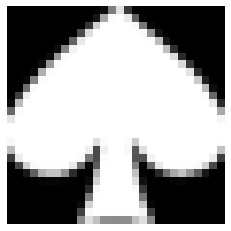

In [46]:
# Display image
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.imshow(suits_df[0][1], cmap='gray')
#ax.set_title(f'Game {game} - Round {round_nb}')
ax.axis('off')
plt.show()

In [248]:
def find_fourier_descriptors(img):
    """ 
    Finds and returns the Fourier descriptors of an image contour.
    
    The function first find the external contours of the image 
    
    Parameters
    ----------
    img : np.ndarray (MxM)
        A 2D image

    Returns
    -------
    np.ndarray
        The Fourier descriptors of the image
    """
    # Find the external contours of the image
    contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    # We resample the contours so that they have the same number of points (which impact the DFT)
    contours_resampled = resample(contours[0], 50)
    
    ### Plot the contours if necessary
    #plt.plot(np.array(contours_resampled).squeeze()[:,0], np.array(contours_resampled).squeeze()[:,1])
    #plt.imshow(img,cmap="gray")
    #plt.show()

    # Obtain the list of 2D coordinates for the external contour of the main object in the image
    digit_contour = contours_resampled[:,0,:]
    
    # Convert the coordinates from x-y axis to a complex representation 
    digit_contour_complex = np.empty(digit_contour.shape[:-1], dtype=complex)
    digit_contour_complex.real = digit_contour[:, 0]
    digit_contour_complex.imag = digit_contour[:, 1]
    
    fourier_descriptors = np.fft.fft(digit_contour_complex)
    
    return fourier_descriptors


In [249]:
def extract_2D_features_from_fourier_descriptors(fourier_descriptors):
    """ 
    Compute two features from the fourier descriptors.
    
    The features are invariant to translation, rotation and scaling. 
    
    Parameters
    ----------
    fourier_descriptors : np.ndarray (N,)
        An array of fourier descriptors

    Returns
    -------
    (float, float)
        A tuple containing two features based on Fourier descriptors, 
        invariant to translation, rotation and scaling.
    """
    # Take the amplitute of f1, f2, f3 (invariant to translation and rotation)
    A1 = np.abs(fourier_descriptors[1])
    A2 = np.abs(fourier_descriptors[2])
    A3 = np.abs(fourier_descriptors[3])
    A4 = np.abs(fourier_descriptors[4])
    A5 = np.abs(fourier_descriptors[5])
    A6 = np.abs(fourier_descriptors[6])
    A7 = np.abs(fourier_descriptors[7])

    # Compute the ratio of two coefficients (invariant to scaling)
    feature1 = A1/A7
    feature2 = A2/A7
    feature3 = A3/A7
    feature4 = A4/A7
    feature5 = A5/A7
    feature6 = A6/A7

    return (feature1, feature2, feature3, feature4, feature5, feature6)

In [250]:
def extract_2d_features_from_suits(suits):
    suits_2D_features = {
        'H': [],
        'D': [],
        'C': [],
        'S': []
    }
    
    for card_str, suit in suits:
        suit_fourier_descriptors = find_fourier_descriptors(img_as_ubyte(suit))
        suit_2D_features = extract_2D_features_from_fourier_descriptors(suit_fourier_descriptors)
        suits_2D_features[card_str[1]].append(suit_2D_features)
    
    return suits_2D_features

In [251]:
suits_features = extract_2d_features_from_suits(suits_df)

hearts_features = np.array(suits_features['H'])
diamonds_features = np.array(suits_features['D'])
clubs_features = np.array(suits_features['C'])
spades_features = np.array(suits_features['S'])

In [264]:
hearts_df = pd.DataFrame(hearts_features, columns=['f1','f2','f3','f4','f5','f6'])

,f1,f2,f3,f4,f5,f6
0,4.796103,23.581416,2.493555,6.496597,2.122071,1.308828
1,8.536946,28.400298,2.311555,7.053818,3.037223,1.345837
2,16.726986,45.889585,4.313874,12.131572,5.323092,2.506757
3,7.177107,34.273504,0.846140,8.102755,1.307529,1.441770
4,124.126334,193.714141,8.192716,37.134385,6.290114,17.973185
...,...,...,...,...,...,...
183,40.347459,63.374849,6.275004,15.234536,3.799766,6.436337
184,13.750550,44.792313,4.404023,11.272653,5.608919,2.526985
185,5.363837,21.523243,1.837322,5.947457,1.276183,1.360110
186,23.239105,116.652173,5.282259,27.729275,9.188479,2.138840


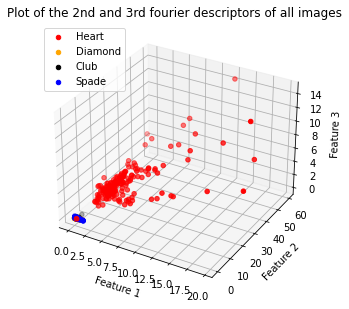

In [245]:
# Plot descriptors
fig = plt.figure(1, figsize=(12, 5))
ax = fig.add_subplot(projection='3d')

ax.scatter(hearts_features[:,0], hearts_features[:,1], hearts_features[:,2], label="Heart", color='red') 
ax.scatter(diamonds_features[:,0], diamonds_features[:,1], diamonds_features[:,2], label="Diamond", color='orange')   
ax.scatter(clubs_features[:,0], clubs_features[:,1], clubs_features[:,2], label="Club", color='black')
ax.scatter(spades_features[:,0], spades_features[:,1], spades_features[:,2], label="Spade", color='blue')   

ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
ax.set_zlabel("Feature 3")


ax.set_title("Plot of the 2nd and 3rd fourier descriptors of all images")
ax.legend()
plt.show()

---
### 4.1 Example Final results

Example of output you **should** provide the day of the final exam.

In [ ]:
# Creates dummy predictions (toy exmaple)
pred_rank = np.array(["0D"]*4*13).reshape((13, 4)) # Everyone played the "0 of spade".
pred_dealer = [1]*13                # List of players selected as dealer for each round
pred_pts_stand = [0,0,0,13]         # Player 4 won 13 points with standard rules.
pred_pts_advan = [0,0,8,7]          # Player 3 and 4 won 8 and 7 points with adv, rules respectively.

print_results(
    rank_colour=pred_rank, 
    dealer=pred_dealer, 
    pts_standard=pred_pts_stand,
    pts_advanced=pred_pts_advan,
)

---
### 4.2 Example Accuracy

Example of code you can use to validate the performance of your model. Be careful the day of the exam you will not have access to the ground truth of the predictions.

In [ ]:
# Load ground truth from game 1
cgt = pd.read_csv('train_games/game1/game1.csv', index_col=0)
cgt_rank = cgt[['P1', 'P2', 'P3', 'P4']].values

# Compute accuracy of prediction
acc_standard = evaluate_game(pred_rank, cgt_rank, mode_advanced=False)
acc_advanced = evaluate_game(pred_rank, cgt_rank, mode_advanced=True)
print("Your model accuracy is: Standard={:.3f}, Advanced={:.3f}".format(acc_standard, acc_advanced))